# 데이터 불러오기

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq
import re
from pathlib import Path

## 데이터로드

In [2]:
MOVIE_CSV = "./movie_tot.csv"
GOODBOOKS_CSV = "./goodbooks.csv"

In [3]:
import pandas as pd

movie = pd.read_csv(MOVIE_CSV)
book = pd.read_csv(GOODBOOKS_CSV)

In [9]:
OUT_DIR   = Path("./interim"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# 메모리 절약용 dtype
movie_dtypes = {"movieId":"int32"}
book_dtypes  = {"user_id":"int32","book_id":"int32","rating":"float32"}

# 정규식 미리 컴파일 (속도↑, RAM↓)
non_alnum = re.compile(r"[^a-z0-9+#&'\-\s]")
multispace = re.compile(r"\s+")
def clean_text(s:str) -> str:
    if not isinstance(s, str): s = "" if pd.isna(s) else str(s)
    s = s.lower()
    s = non_alnum.sub(" ", s)
    s = multispace.sub(" ", s).strip()
    return s

### movie tag vs book tag_list

In [21]:
import pandas as pd
import re
from collections import Counter
from pathlib import Path

OUT = Path("./interim"); OUT.mkdir(parents=True, exist_ok=True)

# --- 태그 정규화: 소문자, 양쪽 공백 제거, 중복 공백 1칸 ---
_non_alnum_keep_space = re.compile(r"[^a-z0-9+#&'\-\s]")
_multispace = re.compile(r"\s+")
def norm_tag(s: str) -> str:
    if not isinstance(s, str): s = "" if pd.isna(s) else str(s)
    s = s.lower().strip()
    s = _non_alnum_keep_space.sub(" ", s)
    s = _multispace.sub(" ", s).strip()
    return s

movie_cnt = Counter()
book_cnt  = Counter()

# -------- 영화 태그 집계: '|' 구분 --------
for chunk in pd.read_csv(
    MOVIE_CSV, usecols=["tag"], dtype={"tag":"string"},
    chunksize=200_000, engine="c"
):
    for t_str in chunk["tag"].fillna(""):
        tags = [norm_tag(x) for x in str(t_str).split("|") if x]
        movie_cnt.update([t for t in tags if t])

# -------- 책 태그 집계: ',' 구분 --------
for chunk in pd.read_csv(
    GOODBOOKS_CSV, usecols=["tag_list"], dtype={"tag_list":"string"},
    chunksize=200_000, engine="c"
):
    for t_str in chunk["tag_list"].fillna(""):
        tags = [norm_tag(x) for x in str(t_str).split(",") if x]
        book_cnt.update([t for t in tags if t])

# ------ 유니크/빈도 테이블 생성 ------
movie_df = pd.DataFrame(movie_cnt.items(), columns=["tag","movie_count"]).sort_values("movie_count", ascending=False)
book_df  = pd.DataFrame(book_cnt.items(),  columns=["tag","book_count"]).sort_values("book_count", ascending=False)

movie_df.to_csv(OUT/"movie_tag_freq.csv", index=False)
book_df.to_csv(OUT/"book_tag_freq.csv", index=False)

# ------ 유니크 개수 & 예시 출력 ------
movie_vocab = set(movie_cnt.keys())
book_vocab  = set(book_cnt.keys())

print(f"🎬 영화 태그 유니크 수: {len(movie_vocab):,}")
print(movie_df.head(10).to_string(index=False))
print("\n📚 책 태그 유니크 수:  ", len(book_vocab))
print(book_df.head(10).to_string(index=False))

# ------ 교집합/합집합/Jaccard ------
inter = movie_vocab & book_vocab
union = movie_vocab | book_vocab
jaccard = (len(inter) / len(union)) if union else 0.0

print(f"\n🔗 교집합: {len(inter):,}  |  합집합: {len(union):,}  |  Jaccard: {jaccard:.4f}")

# 교집합 상위 100 (양쪽 빈도 합 기준)
overlap_df = (
    movie_df.merge(book_df, on="tag", how="inner")
            .assign(total = lambda x: x.movie_count + x.book_count)
            .sort_values("total", ascending=False)
            .head(100)
)
overlap_df.to_csv(OUT/"overlap_top100.csv", index=False)

# 전체 유니크 목록 저장(원하면 샘플만 봐도 됨)
pd.Series(sorted(movie_vocab)).to_csv(OUT/"movie_tags_unique.txt", index=False, header=False)
pd.Series(sorted(book_vocab)).to_csv(OUT/"book_tags_unique.txt", index=False, header=False)

print("\n✅ 저장:")
print(f"- {OUT/'movie_tag_freq.csv'}")
print(f"- {OUT/'book_tag_freq.csv'}")
print(f"- {OUT/'overlap_top100.csv'}")
print(f"- {OUT/'movie_tags_unique.txt'} , {OUT/'book_tags_unique.txt'}")


🎬 영화 태그 유니크 수: 1,127
         tag  movie_count
       drama     16548253
      action     15149285
      comedy     14231586
   adventure      9965265
    thriller      9336646
      sci-fi      8098517
     romance      7811081
       crime      7047101
     fantasy      6242651
imdb top 250      5640396

📚 책 태그 유니크 수:   32964
              tag  book_count
          to-read     5789406
        favorites     5657035
            owned     5647841
      books-i-own     5611979
          fiction     5544358
          library     5542240
currently-reading     5541006
      owned-books     5508772
           to-buy     5236258
          default     5114592

🔗 교집합: 562  |  합집합: 33,529  |  Jaccard: 0.0168

✅ 저장:
- interim/movie_tag_freq.csv
- interim/book_tag_freq.csv
- interim/overlap_top100.csv
- interim/movie_tags_unique.txt , interim/book_tags_unique.txt


### TF-IDF 불용어 목록

In [10]:
import pandas as pd
from pathlib import Path

# --- 설정 ---
MOVIE_TAGS_PATH = Path("./interim/movie_tags_unique.txt")
BOOK_FREQ_PATH = Path("./interim/book_tag_freq.csv")

# "나쁜 태그"로 간주할 상위 빈도 백분위수 (예: 0.99 = 상위 1%)
# 이 값을 조절하며 불용어 목록을 조절할 수 있습니다.
TOP_FREQ_QUANTILE = 0.99 

# --- 1. Allow-List 생성 (영화 태그) ---
try:
    with open(MOVIE_TAGS_PATH, 'r') as f:
        # 영화 태그는 전처리가 되었을 수 있으므로, clean_text를 적용해야 하지만
        # 여기서는 단순화를 위해 파일의 내용을 그대로 사용합니다.
        # (원본 코드의 clean_text 함수가 여기에도 있다고 가정)
        allow_list_set = {clean_text(line.strip()) for line in f if line.strip()}
    print(f"✅ 'Allow-List' (영화 태그) {len(allow_list_set)}개 로드 완료.")

except FileNotFoundError:
    print(f"❌ ERROR: {MOVIE_TAGS_PATH} 파일을 찾을 수 없습니다.")
    allow_list_set = set()

# --- 2. Book 태그 빈도 기반 불용어 후보군 찾기 ---
try:
    book_tags_df = pd.read_csv(BOOK_FREQ_PATH)
    
    # 3. 빈도수(book_count)가 매우 높은 임계값(Threshold) 찾기
    threshold_count = book_tags_df['book_count'].quantile(TOP_FREQ_QUANTILE)
    
    # 4. 임계값보다 빈도가 높은 태그 (불용어 후보)
    stopword_candidates_df = book_tags_df[
        book_tags_df['book_count'] > threshold_count
    ]
    stopword_candidate_set = set(stopword_candidates_df['tag'])
    
    print(f"✅ 빈도수 임계값 ({TOP_FREQ_QUANTILE*100}%) : {threshold_count:,.0f} 회 이상")
    print(f"✅ 불용어 후보 (빈도수 높은 태그): {len(stopword_candidate_set)}개")

    # 5. [핵심 로직] 
    #    불용어 후보 중에서, Allow-List(영화 태그)에 포함된 것은 제외!
    auto_stopword_set = stopword_candidate_set - allow_list_set
    
    print(f"✅ 최종 '스마트 불용어' 목록: {len(auto_stopword_set)}개 생성 완료.")
    
    # --- (검증용) 생성된 불용어 목록 일부 출력 ---
    print("\n--- 자동 생성된 불용어 (일부) ---")
    print(sorted(list(auto_stopword_set))) 
    # 'to-read', 'favorites', 'owned' 등이 여기 보여야 합니다.

except FileNotFoundError:
    print(f"❌ ERROR: {BOOK_FREQ_PATH} 파일을 찾을 수 없습니다.")
    auto_stopword_set = set() # 실패 시 비어있는 셋 사용

✅ 'Allow-List' (영화 태그) 1127개 로드 완료.
✅ 빈도수 임계값 (99.0%) : 306,292 회 이상
✅ 불용어 후보 (빈도수 높은 태그): 330개
✅ 최종 '스마트 불용어' 목록: 271개 생성 완료.

--- 자동 생성된 불용어 (일부) ---
['1001', '1001-books', '1001-books-to-read', '1001-books-to-read-before-you-die', '1001-books-you-must-read-before-you', '19th-century', '2006', '2012-reads', '2013-reads', '2014-books', '2014-reads', '2015-books', '2015-reading-challenge', '2015-reads', '2016-reads', '20th-century', '21st-century', '3-stars', '4-stars', '5-star', '5-stars', 'abandoned', 'action-adventure', 'adult', 'adult-fiction', 'all-time-favorites', 'america', 'american', 'american-lit', 'american-literature', 'audible', 'audio', 'audio-book', 'audio-books', 'audiobook', 'audiobooks', 'autobiography', 'banned-books', 'biographies', 'biography-memoir', 'book-club', 'book-club-books', 'book-club-reads', 'book-group', 'book-to-movie', 'bookclub', 'books-i-have', 'books-i-own', 'bookshelf', 'borrowed', 'british-literature', 'calibre', 'chick-lit', 'chicklit', 'childhoo

### 책 문서: 청크 + 태그 상위 N개만 사용

In [11]:

GOODBOOKS_CSV = "./goodbooks.csv"
OUT_DIR  = Path("./interim"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PATH = OUT_DIR / "book_docs_merged.parquet"

# 기존 clean_text / auto_stopword_set를 그대로 사용한다고 가정
_non_alnum = re.compile(r"[^a-z0-9+#&'\-\s]")
_multispace = re.compile(r"\s+")
def clean_text(s):
    if not isinstance(s, str): s = "" if pd.isna(s) else str(s)
    s = s.lower()
    s = _non_alnum.sub(" ", s)
    s = _multispace.sub(" ", s).strip()
    return s

# 쉼표로 분리된 tag_list들을 안전하게 합쳐주는 함수
def _concat_comma(series: pd.Series) -> str:
    vals=[]
    for s in series.dropna().astype(str):
        vals.extend([x for x in s.split(",") if x])
    return ",".join(vals)

# 1) 청크별로 book_id 단위 집계 (메모리 안전)
agg_chunks=[]
usecols=["book_id","title","tag_list"]  # 평점/유저ID는 불필요
dtypes = {"book_id":"int32","title":"string","tag_list":"string"}

for chunk in pd.read_csv(GOODBOOKS_CSV, usecols=usecols, dtype=dtypes,
                         chunksize=500_000, engine="c"):
    g = (chunk
         .groupby("book_id", as_index=False)
         .agg(title=("title","first"),            # 대표 title (첫 값)
              tag_list=("tag_list", _concat_comma) # 태그 누적 합치기
         ))
    agg_chunks.append(g)

# 2) 전체 재집계(청크간 중복 book_id 정리)
agg = pd.concat(agg_chunks, ignore_index=True)
agg = (agg.groupby("book_id", as_index=False)
          .agg(title=("title","first"),
               tag_list=("tag_list", _concat_comma))
          .sort_values("book_id")
          .reset_index(drop=True))

# (선택) 같은 태그가 여러 번 합쳐졌다면, clean 후 dedup
def _dedup_and_filter_tags(raw: str, stopword_set) -> list:
    keep=[]
    seen=set()
    for t in (raw or "").split(","):
        t2 = clean_text(t)
        if not t2: 
            continue
        if t2 in stopword_set: 
            continue
        if t2 in seen: 
            continue
        seen.add(t2)
        keep.append(t2)
    return keep

# 3) 문서 생성 (책 1권 = 1행)
docs=[]
for row in agg.itertuples(index=False):
    title = clean_text(getattr(row,"title"))
    tags  = _dedup_and_filter_tags(getattr(row,"tag_list"), auto_stopword_set)
    tags  = tags[:50]                      # topk
    if len(tags) > 300:                    # max_tokens
        tags = tags[:300]
    doc = (title + " " + " ".join(tags)).strip()
    docs.append(doc)

# 4) 단일 Parquet 저장
tbl = pa.Table.from_pydict({
    "book_id": pa.array(agg["book_id"].astype("int32").values, type=pa.int32()),
    "doc": pa.array(docs, type=pa.string()),
})
pq.write_table(tbl, OUT_PATH, compression="zstd")
print(f"✅ rewrote (1 row per book): {OUT_PATH}  rows={tbl.num_rows:,}")

# (검증) 고유성 체크
print("unique book_id:", agg["book_id"].nunique())

✅ rewrote (1 row per book): interim/book_docs_merged.parquet  rows=9,759
unique book_id: 9759


### 영화 문서: 청크 단위 + 상위 태그만 사용 + 복제 상한

In [12]:
import pandas as pd
import pyarrow as pa, pyarrow.parquet as pq
import re
from pathlib import Path

OUT_DIR  = Path("./interim"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PATH = OUT_DIR / "movie_docs_merged.parquet"

MOVIE_CSV = "./movie_tot.csv"

# dtype
movie_dtypes = {"movieId":"int32", "title":"string", "tag":"string", "relevance":"string"}

# 전처리
_non_alnum = re.compile(r"[^a-z0-9+#&'\-\s]")
_multispace = re.compile(r"\s+")
def clean_text(s):
    if not isinstance(s, str):
        s = "" if pd.isna(s) else str(s)
    s = s.lower()
    s = _non_alnum.sub(" ", s)
    s = _multispace.sub(" ", s).strip()
    return s

def _merge_tag_rel(tag_str: str, rel_str: str):
    """
    파이프 문자열(tag, relevance)을 파싱하여
    - 태그 정규화(clean)
    - 같은 태그 중복 시 max(relevance) 선택
    - relevance 내림차순 정렬
    반환: (tags:list[str], rels:list[float])
    """
    tags = [t for t in (tag_str or "").split("|") if t]
    try:
        rels = [float(x) for x in (rel_str or "").split("|") if x]
    except:
        rels = []
    if len(rels) != len(tags):
        rels = [1.0] * len(tags)

    best = {}
    for t, r in zip(tags, rels):
        t2 = clean_text(t)
        if not t2:
            continue
        # 동일 태그 중 최대 가중치만 유지
        if t2 not in best or r > best[t2]:
            best[t2] = float(r)

    if not best:
        return [], []

    items = sorted(best.items(), key=lambda x: x[1], reverse=True)
    tags_out = [k for k, _ in items]
    rels_out = [v for _, v in items]
    return tags_out, rels_out

def build_movie_docs(df, topk=30, max_dup=6, max_tokens=300):
    out_ids, out_docs = [], []

    for row in df.itertuples(index=False):
        mid   = int(getattr(row, "movieId"))
        title = clean_text(getattr(row, "title", ""))  # title 없으면 빈 문자열

        tags_raw = getattr(row, "tag", "") or ""
        rels_raw = getattr(row, "relevance", "") or ""

        tags, rels = _merge_tag_rel(tags_raw, rels_raw)

        # 상위 topk
        tags, rels = tags[:topk], rels[:topk]

        # relevance 기반 토큰 중복 (0~1 가정)
        toks, budget = [], max_tokens
        for t, r in zip(tags, rels):
            dup = max(1, min(int(round(r * max_dup)), max_dup))
            take = min(dup, budget)
            if take <= 0:
                break
            toks.extend([t] * take)
            budget -= take

        doc = (title + " " + " ".join(toks)).strip()
        out_ids.append(mid)
        out_docs.append(doc)

    tbl = pa.Table.from_pydict({
        "movieId": pa.array(out_ids, type=pa.int32()),
        "doc": pa.array(out_docs, type=pa.string()),
    })
    return tbl

# --- 핵심: 집계(groupby/_concat_pipe) 없이 그대로 읽어서 처리 ---
df = pd.read_csv(MOVIE_CSV,
                 usecols=["movieId","title","tag","relevance"],  # title 없으면 제거 가능
                 dtype=movie_dtypes)

# 필요 시 title 컬럼이 없을 때 대비
if "title" not in df.columns:
    df["title"] = ""

# movieId 고유성 보장 (혹시라도 중복행이 있다면 첫 행만 사용)
if not df["movieId"].is_unique:
    df = df.drop_duplicates(subset=["movieId"], keep="first").reset_index(drop=True)

tbl = build_movie_docs(df, topk=30, max_dup=6, max_tokens=300)
pq.write_table(tbl, OUT_PATH, compression="zstd")
print(f"✅ wrote (1 row per movie): {OUT_PATH}  rows={tbl.num_rows:,}")


✅ wrote (1 row per movie): interim/movie_docs_merged.parquet  rows=12,586


In [3]:
import pandas as pd
md = pd.read_parquet("./interim/movie_docs_merged.parquet")  # 24,438,721 x 2  (doc은 중복/중앙정렬된 토큰열일 수 있음)
bd = pd.read_parquet("./interim/book_docs_merged.parquet") # 5,795,185  x 2
print(md.shape, md.head(5))
print(bd.shape, bd.head(5))


(12586, 2)    movieId                                                doc
0      296  pulp fiction comedy comedy comedy comedy comed...
1      306  three colors red trois couleurs rouge drama dr...
2      307  three colors blue trois couleurs bleu drama dr...
3      665  underground comedy comedy comedy comedy comedy...
4      899  singin' in the rain comedy comedy comedy comed...
(9759, 2)    book_id                                                doc
0        1  the hunger games the hunger games #1 dystopia ...
1        2  harry potter and the sorcerer's stone harry po...
2        3  twilight twilight #1 fantasy vampires vampire ...
3        4  to kill a mockingbird classic school literatur...
4        5  the great gatsby classic literature school rom...


In [5]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from joblib import dump
from numpy.linalg import norm

# 경로
DATA_DIR = Path("./")
OUT_DIR  = Path("./interim"); OUT_DIR.mkdir(parents=True, exist_ok=True)
MOVIE_PARQ = OUT_DIR/"movie_docs_merged.parquet"   # cols: movieId, doc

# 0-1) 데이터 로드
movie_docs = pd.read_parquet(MOVIE_PARQ)
corpus = movie_docs["doc"].astype(str).tolist()

# 0-2) 텍스트 -> TFIDF (비-BERT)
tfidf = TfidfVectorizer(min_df=5, max_df=0.5, ngram_range=(1,2),
                        sublinear_tf=True, dtype=np.float32)
X = tfidf.fit_transform(corpus)          # sparse [n_movies, |V|]

# 0-3) 차원 축소 (LSI)
svd = TruncatedSVD(n_components=256, random_state=42)
Z = svd.fit_transform(X).astype("float32")     # [n_movies, 256]
Z = normalize(Z)                                # cosine=dot

# 0-4) 저장
movie_emb = pd.DataFrame(Z)
movie_emb["movieId"] = movie_docs["movieId"].values
movie_emb.to_parquet(OUT_DIR/"movie_vec.parquet", index=False)

dump({"tfidf": tfidf, "svd": svd}, OUT_DIR/"movie_text_model.joblib")
print("✅ 0단계 완료: movie_vec.parquet, movie_text_model.joblib 저장")


✅ 0단계 완료: movie_vec.parquet, movie_text_model.joblib 저장


In [81]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

DATA_DIR = Path("./")
OUT_DIR  = Path("./interim")

# 1) 평점 로드(필요 컬럼만)
ratings = pd.read_csv(DATA_DIR/"movie_tot.csv", usecols=["userId","movieId","rating"])

# 2) 컬럼 표준화
ratings = ratings.rename(columns={"userId":"user_id","movieId":"movie_id"})
ratings["user_id"] = ratings["user_id"].astype("int32")
ratings["movie_id"] = ratings["movie_id"].astype("int32")
ratings["rating"]  = ratings["rating"].astype("float32")

# 3) 유저별로 7:2:1 분할 (train 70%, val 20%, test 10%)
def split_user_group(g, seed=42):
    idx = g.index.to_numpy()
    if len(idx) < 3:
        return g.assign(split="train")
    train_idx, temp_idx = train_test_split(idx, test_size=0.30, random_state=seed)  # 70 / 30
    # 30% 중에서 2:1 → val 20, test 10
    val_idx, test_idx = train_test_split(temp_idx, test_size=(1/3), random_state=seed)
    s = pd.Series(index=g.index, data="train")
    s.loc[val_idx]  = "val"
    s.loc[test_idx] = "test"
    return g.assign(split=s.values)

splitted = ratings.groupby("user_id", group_keys=False).apply(split_user_group)

Train = splitted[splitted["split"]=="train"][["user_id","movie_id","rating"]].copy()
Val   = splitted[splitted["split"]=="val"][["user_id","movie_id","rating"]].copy()
Test  = splitted[splitted["split"]=="test"][["user_id","movie_id","rating"]].copy()

print(Train.shape, Val.shape, Test.shape)


(17035752, 3) (4885672, 3) (2517297, 3)


In [85]:
import numpy as np
import pandas as pd

# 1) 임베딩 테이블 표준화
def standardize_embed_table(df: pd.DataFrame, index_name: str):
    # 인덱스 보장
    if index_name in df.columns:
        df = df.set_index(index_name)
    # 벡터가 한 칼럼(object/list)로 들어간 케이스 풀기
    if df.shape[1] == 1 and df.dtypes.iloc[0] == 'object':
        vecs = df.iloc[:,0].apply(lambda v: np.asarray(v).ravel())
        dim = int(vecs.iloc[0].shape[0])
        df = pd.DataFrame(np.vstack(vecs.values), index=df.index,
                          columns=[f"f{i}" for i in range(dim)])
        return df
    # 컬럼명이 숫자(0..255)면 f접두어로 통일
    cols = df.columns.tolist()
    if all(isinstance(c, (int, np.integer, np.int64)) for c in cols):
        df = df.rename(columns={c: f"f{int(c)}" for c in cols})
    return df

# 2) 공통 피처 맞춰서 안전 내적
def safe_dot_row(Eu_df, M_df, uid, mid):
    # 공통 피처만 사용
    common = [c for c in Eu_df.columns if c in M_df.columns]
    if not common:
        raise RuntimeError("공통 피처 컬럼이 없습니다. (예: f0..f255로 통일 필요)")
    u = Eu_df.loc[uid, common].to_numpy(dtype=np.float32).ravel()
    m = M_df.loc[mid, common].to_numpy(dtype=np.float32).ravel()
    if u.shape != m.shape:
        raise RuntimeError(f"피처 차원 불일치: user {u.shape}, movie {m.shape}")
    return float(np.dot(u, m))

# --- 여기서 M, Eu를 표준화하세요 ---
M = pd.read_parquet("./interim/movie_vec.parquet").rename(columns={"movieId":"movie_id"})
Eu = pd.read_parquet("./interim/user_vec.parquet")
M = standardize_embed_table(M, "movie_id")
Eu = standardize_embed_table(Eu, "user_id")

# 디버그 출력
print("Eu shape:", Eu.shape, "first cols:", Eu.columns[:5].tolist())
print("M  shape:", M.shape,  "first cols:", M.columns[:5].tolist())

# 기존 dot 대신 safe_dot_row 사용 예시:
# s = safe_dot_row(Eu, M, uid, mid)


Eu shape: (53399, 256) first cols: ['f0', 'f1', 'f2', 'f3', 'f4']
M  shape: (12586, 256) first cols: ['0', '1', '2', '3', '4']


In [87]:
# 1) M 컬럼명 '0','1',... → 'f0','f1',...
M = M.copy()
M.columns = [f"f{int(c)}" if str(c).isdigit() else c for c in M.columns]

# 2) 공통 피처 교집합 정렬(안전)
feat = [c for c in Eu.columns if c in M.columns]
Eu = Eu[feat]
M  = M[feat]

print("Eu cols head:", Eu.columns[:5].tolist())
print("M  cols head:", M.columns[:5].tolist())


Eu cols head: ['f0', 'f1', 'f2', 'f3', 'f4']
M  cols head: ['f0', 'f1', 'f2', 'f3', 'f4']


In [88]:
from sklearn.linear_model import LinearRegression
from joblib import dump
import numpy as np

def dot(u,b): return float(np.dot(u, b))

X_s, y_r = [], []
for uid, mid, r in Val.itertuples(index=False):
    if uid in Eu.index and mid in M.index:
        s = safe_dot_row(Eu, M, uid, mid)  # ← 여기만 교체
        X_s.append([s])               # (N,1)
        y_r.append(float(r))

X_s = np.asarray(X_s, np.float32)
y_r = np.asarray(y_r, np.float32)
reg = LinearRegression().fit(X_s, y_r)
print("alpha, beta =", reg.coef_[0], reg.intercept_)
dump(reg, OUT_DIR/"movie_calibrator_lr.joblib")


alpha, beta = 0.60432535 3.4721816


['interim/movie_calibrator_lr.joblib']

In [89]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import load

reg = load(OUT_DIR/"movie_calibrator_lr.joblib")

y_true, y_pred = [], []
for uid, mid, r in Test.itertuples(index=False):
    if uid in Eu.index and mid in M.index:
        s = dot(Eu.loc[uid].values, M.loc[mid].values)
        p = float(reg.predict([[s]])[0])
        # 평점 스케일 보정(선택): 1~5
        p = min(5.0, max(1.0, p))
        y_true.append(float(r))
        y_pred.append(p)

print("pairs for regression:", len(y_true))
rmse = sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"[Movie] RMSE={rmse:.4f}, MAE={mae:.4f}")


pairs for regression: 826459
[Movie] RMSE=1.0580, MAE=0.8399


In [93]:
import re, numpy as np, pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

OUT_DIR = Path("./interim")

# 1) 메타/문서 로드 (title, doc → tags 추출용)
movie_docs = pd.read_parquet(OUT_DIR/"movie_docs_merged.parquet")  # cols: movieId, doc
movie_docs = movie_docs.rename(columns={"movieId":"movie_id"}).set_index("movie_id")

# title은 movie_tot.csv에서 가져오기 (없으면 빈 문자열)
try:
    movie_meta = pd.read_csv("./movie_tot.csv", usecols=["movieId","title"]).drop_duplicates("movieId")
    movie_meta = movie_meta.rename(columns={"movieId":"movie_id"}).set_index("movie_id")
except Exception:
    movie_meta = pd.DataFrame()

_non_alnum = re.compile(r"[^a-z0-9+#&'\-\s]")
_multispace = re.compile(r"\s+")
def top_tags_from_doc(doc: str, topn=5):
    if not isinstance(doc, str): return []
    s = doc.lower()
    s = _non_alnum.sub(" ", s)
    s = _multispace.sub(" ", s).strip()
    toks = [t for t in s.split() if t]
    # 제목 토큰까지 섞여 있을 수 있으므로 길이 2 이상 위주
    from collections import Counter
    cnt = Counter([t for t in toks if len(t) >= 2])
    return [w for w,_ in cnt.most_common(topn)]

def title_of(mid):
    if len(movie_meta) and mid in movie_meta.index:
        t = movie_meta.loc[mid, "title"]
        return str(t) if isinstance(t, str) else ""
    return ""

# 2) 공통 피처명 정렬(f0..f255로 통일되어 있다면 스킵해도 됨)
if not all(str(c).startswith("f") for c in M.columns):
    M = M.copy(); M.columns = [f"f{int(c)}" if str(c).isdigit() else c for c in M.columns]
feat = [c for c in Eu.columns if c in M.columns]
Eu = Eu[feat]; M = M[feat]

def user_movie_report(uid=None, K=15, pos_threshold=4):
    # 유저 자동 선택(임베딩 있고 Test 상호작용 많은 유저)
    test_users = Test["user_id"].unique()
    if uid is None:
        counts = Test["user_id"].value_counts()
        cand = [u for u,n in counts.items() if (u in Eu.index) and (n>=10)]
        if not cand:
            cand = [u for u in test_users if u in Eu.index]
        uid = int(cand[0])

    if uid not in Eu.index:
        raise ValueError(f"유저 {uid}는 Eu에 없습니다.")

    uvec = Eu.loc[uid].values.astype("float32")
    g = Test[Test["user_id"]==uid][["movie_id","rating"]].copy()
    g = g[g["movie_id"].isin(M.index)]
    if len(g)==0:
        raise RuntimeError("해당 유저의 Test 영화가 임베딩에 없습니다.")

    scores, preds, titles, tags5 = [], [], [], []
    for mid in g["movie_id"].tolist():
        mvec = M.loc[mid].values.astype("float32")
        s = float(np.dot(uvec, mvec))
        scores.append(s)
        p = float(reg.predict([[s]])[0])
        p = float(np.clip(p, 1.0, 5.0))
        preds.append(p)
        titles.append(title_of(mid))
        doc = movie_docs.loc[mid]["doc"] if mid in movie_docs.index else ""
        tags5.append(", ".join(top_tags_from_doc(doc, topn=5)))

    g["score"] = scores
    g["pred"]  = preds
    g["rel"]   = (g["rating"]>=pos_threshold).astype(int)
    g["title"] = titles
    g["tags_top5"] = tags5

    g_sorted = g.sort_values("score", ascending=False).reset_index(drop=True)
    g_sorted.index = g_sorted.index + 1  # rank 시작 1
    cols = ["movie_id","title","tags_top5","score","pred","rating","rel"]
    display(g_sorted.loc[:K, cols])

    # 유저별 지표도 하단에 프린트
    rmse = sqrt(mean_squared_error(g_sorted["rating"], g_sorted["pred"]))
    mae  = mean_absolute_error(g_sorted["rating"], g_sorted["pred"])
    print(f"[유저 {uid}] rows={len(g_sorted)}  RMSE={rmse:.4f}  MAE={mae:.4f}")

    return uid, g_sorted

# 실행 예시
uid, g_sorted = user_movie_report(uid=None, K=15, pos_threshold=4)


,movie_id,title,tags_top5,score,pred,rating,rel
1,3926,Voyage to the Bottom of the Sea,"adventure, sci-fi, science, fiction, submarine",0.572747,3.818307,3.0,0
2,32076,Godzilla vs. The Sea Monster (Gojira-Ebira-Mos...,"action, adventure, fantasy, sci-fi, island",0.489531,3.768018,1.5,0
3,2661,It Came from Outer Space,"sci-fi, science, fiction, aliens, small",0.476032,3.759859,4.0,1
4,2012,Back to the Future Part III,"time, alternate, future, adventure, comedy",0.455249,3.747300,3.0,0
5,2722,Deep Blue Sea,"action, horror, sci-fi, thriller, shark",0.444298,3.740682,2.0,0
6,2454,"Fly, The","horror, mystery, sci-fi, science, fiction",0.436600,3.736030,4.0,1
7,4952,Morons From Outer Space,"space, comedy, sci-fi, morons, from",0.428089,3.730887,2.0,0
8,379,Timecop,"action, sci-fi, thriller, time, travel",0.408283,3.718918,2.5,0
9,2161,"NeverEnding Story, The","fantasy, book, story, adventure, children",0.405605,3.717299,4.0,1
10,4987,Spacehunter: Adventures in the Forbidden Zone,"space, action, adventure, sci-fi, travel",0.401993,3.715116,1.5,0


[유저 20055] rows=651  RMSE=1.0134  MAE=0.8344


,movie_id,title,tags_top5,score,pred,rating,rel
1,3926,Voyage to the Bottom of the Sea,"adventure, sci-fi, science, fiction, submarine",0.573,3.818,3,0
2,32076,Godzilla vs. The Sea Monster (Gojira-Ebira-Mosura: Nankai no daiketto),"action, adventure, fantasy, sci-fi, island",0.490,3.768,2,0
3,2661,It Came from Outer Space,"sci-fi, science, fiction, aliens, small",0.476,3.760,4,1
4,2012,Back to the Future Part III,"time, alternate, future, adventure, comedy",0.455,3.747,3,0
5,2722,Deep Blue Sea,"action, horror, sci-fi, thriller, shark",0.444,3.741,2,0
6,2454,"Fly, The","horror, mystery, sci-fi, science, fiction",0.437,3.736,4,1
7,4952,Morons From Outer Space,"space, comedy, sci-fi, morons, from",0.428,3.731,2,0
8,379,Timecop,"action, sci-fi, thriller, time, travel",0.408,3.719,2,0
9,2161,"NeverEnding Story, The","fantasy, book, story, adventure, children",0.406,3.717,4,1
10,4987,Spacehunter: Adventures in the Forbidden Zone,"space, action, adventure, sci-fi, travel",0.402,3.715,2,0


/tmp/ipykernel_300777/909410246.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


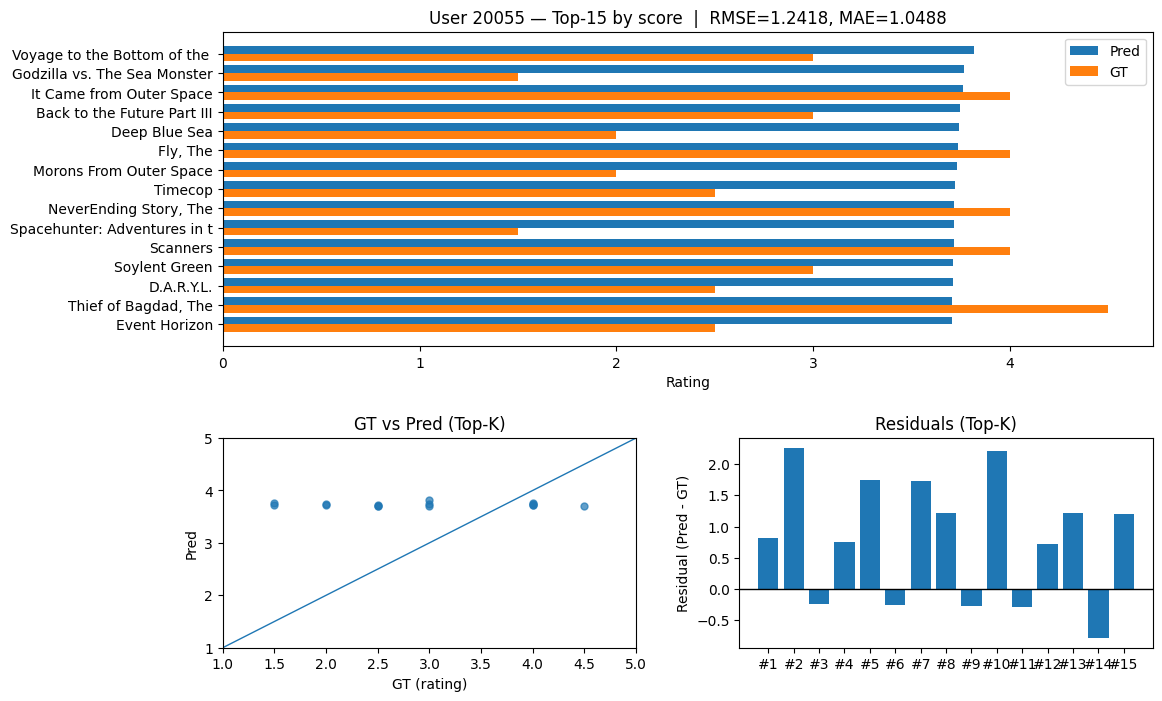

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) 표(상위 K개) — Jupyter에 예쁘게 표시
def show_user_table(g_sorted: pd.DataFrame, K=15):
    cols = ["movie_id","title","tags_top5","score","pred","rating","rel"]
    df = g_sorted.loc[:K, cols].copy()
    # 보기 좋게 포맷팅
    df["score"]  = df["score"].map(lambda x: f"{x:.3f}")
    df["pred"]   = df["pred"].map(lambda x: f"{x:.3f}")
    df["rating"] = df["rating"].map(lambda x: f"{x:.0f}")
    # 스타일(추천): rel=1은 연한 초록 배경, score는 그라디언트
    def rel_style(val): 
        return "background-color: #e8f5e9" if str(val)=="1" else ""
    display(
        df.style.applymap(rel_style, subset=["rel"])
               .background_gradient(cmap="Blues", subset=["score"])
    )

# 2) 시각화 — 상위 K개 막대 + 산점도 + 잔차
def plot_user_gt_pred(g_sorted: pd.DataFrame, K=15, uid=None):
    top = g_sorted.iloc[:K].copy()
    titles = top["title"].fillna("").str.slice(0, 28)  # 레이블 길이 제한

    # 지표
    rmse = sqrt(mean_squared_error(top["rating"], top["pred"]))
    mae  = mean_absolute_error(top["rating"], top["pred"])

    fig = plt.figure(figsize=(12, 8))
    gs  = fig.add_gridspec(2, 2, height_ratios=[3,2], hspace=0.35, wspace=0.25)

    # (a) 수평 막대: Pred vs GT
    ax1 = fig.add_subplot(gs[0, :])
    y = np.arange(len(top))
    ax1.barh(y-0.2, top["pred"].values, height=0.4, label="Pred")
    ax1.barh(y+0.2, top["rating"].values, height=0.4, label="GT")
    ax1.set_yticks(y)
    ax1.set_yticklabels(titles.tolist())
    ax1.invert_yaxis()
    ax1.set_xlabel("Rating")
    title_txt = f"User {uid} — Top-{K} by score  |  RMSE={rmse:.4f}, MAE={mae:.4f}" if uid is not None else f"Top-{K} by score  |  RMSE={rmse:.4f}, MAE={mae:.4f}"
    ax1.set_title(title_txt)
    ax1.legend()

    # (b) 산점도: GT vs Pred (+ y=x 기준선)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(top["rating"], top["pred"], alpha=0.7, s=25)
    ax2.plot([1,5],[1,5], lw=1)
    ax2.set_xlabel("GT (rating)"); ax2.set_ylabel("Pred")
    ax2.set_title("GT vs Pred (Top-K)"); ax2.set_xlim(1,5); ax2.set_ylim(1,5)

    # (c) 잔차: Pred-GT (양수=과대예측)
    ax3 = fig.add_subplot(gs[1, 1])
    resid = top["pred"].values - top["rating"].values
    ax3.bar(np.arange(len(resid)), resid)
    ax3.axhline(0, lw=1, color="k")
    ax3.set_xticks(np.arange(len(resid)))
    ax3.set_xticklabels([f"#{i}" for i in top.index], rotation=0)
    ax3.set_ylabel("Residual (Pred - GT)")
    ax3.set_title("Residuals (Top-K)")
    plt.tight_layout()
    plt.show()

# 사용 예시 --------------------------------------------
# 이미 만든 리포트 함수로 데이터 얻기
# uid, g_sorted = user_movie_report(uid=None, K=15, pos_threshold=4)

K = 15  # 원하는 개수
show_user_table(g_sorted, K=K)
plot_user_gt_pred(g_sorted, K=K, uid=uid)


In [ ]:
from joblib import load
from sklearn.preprocessing import normalize

def encode_text(texts, model_bundle):
    tfidf, svd = model_bundle["tfidf"], model_bundle["svd"]
    Xq = tfidf.transform(texts)
    Zq = svd.transform(Xq).astype("float32")
    return normalize(Zq)

bundle = load(OUT_DIR/"movie_text_model.joblib")

pairs = [("sci-fi", "space opera"),
         ("romance", "gore"),
         ("drama", "comedy")]
vecs = {t: encode_text([t], bundle)[0] for t in {t for p in pairs for t in p}}

def cos(a,b): return float(np.dot(vecs[a], vecs[b]))
for a,b in pairs:
    print(f"cos('{a}','{b}') = {cos(a,b):.3f}")
# 기대: sci-fi ~ space opera ↑, romance ~ gore ↓


cos('sci-fi','space opera') = -0.000
cos('romance','gore') = 0.001
cos('drama','comedy') = -0.007


In [62]:
import numpy as np
import pandas as pd

movie = pd.read_parquet("./interim/movie_docs_merged.parquet")
Z = pd.read_parquet("./interim/movie_vec.parquet").drop("movieId", axis=1).values

# sci-fi 단어가 포함된 문서 중 하나, space opera 단어가 포함된 문서 중 하나 선택
i = movie[movie["doc"].str.contains("sci-fi", regex=False)].index[0]
j = movie[movie["doc"].str.contains("space opera", regex=False)].index[0]

sim = np.dot(Z[i], Z[j])
print(f"cos(movie_sci-fi, movie_spaceopera) = {sim:.3f}")


cos(movie_sci-fi, movie_spaceopera) = 0.387


## book rating prediction

In [63]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

RATINGS_CSV = Path("./goodbooks.csv")
OUT_DIR = Path("./interim"); OUT_DIR.mkdir(exist_ok=True, parents=True)

ratings = pd.read_csv(RATINGS_CSV)[["user_id","book_id","rating"]]

# 충분한 상호작용이 있는 유저만 사용(예: >=5)
cnt = ratings["user_id"].value_counts()
ok_users = cnt[cnt>=5].index
ratings = ratings[ratings.user_id.isin(ok_users)].copy()

def split_user_group(g, train_ratio=0.6, val_ratio=0.2, seed=42):
    idx = g.index.to_numpy()
    if len(idx) < 3:  # 안전장치
        return g.assign(split="train")
    train_idx, temp_idx = train_test_split(idx, test_size=(1-train_ratio), random_state=seed)
    val_size = val_ratio / (1 - train_ratio)
    val_idx, test_idx = train_test_split(temp_idx, test_size=(1 - val_size), random_state=seed)
    s = pd.Series(index=g.index, data="train")
    s.loc[val_idx] = "val"
    s.loc[test_idx] = "test"
    return g.assign(split=s.values)

splitted = ratings.groupby("user_id", group_keys=False).apply(split_user_group)

train_df = splitted[splitted["split"]=="train"].drop(columns="split")
val_df   = splitted[splitted["split"]=="val"].drop(columns="split")
test_df  = splitted[splitted["split"]=="test"].drop(columns="split")

train_df.to_parquet(OUT_DIR/"goodbooks_train.parquet", index=False)
val_df.to_parquet(OUT_DIR/"goodbooks_val.parquet", index=False)
test_df.to_parquet(OUT_DIR/"goodbooks_test.parquet", index=False)

print(train_df.shape, val_df.shape, test_df.shape)


(3455813, 3) (1158984, 3) (1180388, 3)


In [64]:
import numpy as np
from numpy.linalg import norm

# 책 임베딩 로드
B = pd.read_parquet(OUT_DIR/"book_vec.parquet").set_index("book_id")
vec_cols = [c for c in B.columns if c.startswith("f")] or B.columns.tolist()  # 벡터 열

Eu_rows = []
for uid, g in train_df.groupby("user_id"):
    liked = g[g["rating"]==5]["book_id"].values
    if len(liked)==0:
        liked = g[g["rating"]>=4]["book_id"].values
    vecs = B.loc[B.index.intersection(liked), vec_cols].values
    if len(vecs)==0:
        continue
    eu = vecs.mean(axis=0)
    eu = eu / (norm(eu)+1e-9)
    Eu_rows.append((uid, *eu))

Eu = pd.DataFrame(Eu_rows, columns=["user_id"]+[f"f{i}" for i in range(vecs.shape[1])]).set_index("user_id")
Eu.to_parquet(OUT_DIR/"user_vec.parquet")
print("Eu users:", len(Eu))


Eu users: 53399


In [66]:
import pandas as pd
from pathlib import Path

OUT_DIR = Path("./interim")

# 공통: 컬럼명 표준화 함수
def standardize_cols(df: pd.DataFrame):
    # 인덱스에 박혀 있으면 컬럼으로 꺼내기
    if df.index.names and any(n in {"user_id","userId"} for n in df.index.names if n):
        df = df.reset_index()
    if df.index.names and any(n in {"book_id","bookId"} for n in df.index.names if n):
        df = df.reset_index()
    if df.index.name in {"user_id","userId","book_id","bookId"}:
        df = df.reset_index()

    # 현재 컬럼 확인
    cols = set(df.columns)

    # 가능한 대체 이름 매핑
    rename_map = {}
    if "user_id" not in cols:
        if "userId" in cols: rename_map["userId"] = "user_id"
        elif "user" in cols: rename_map["user"] = "user_id"
    if "book_id" not in cols:
        if "bookId" in cols: rename_map["bookId"] = "book_id"
        elif "book" in cols: rename_map["book"] = "book_id"
        elif "item_id" in cols: rename_map["item_id"] = "book_id"
    if "rating" not in cols:
        if "score" in cols: rename_map["score"] = "rating"
        elif "Rate" in cols: rename_map["Rate"] = "rating"

    if rename_map:
        df = df.rename(columns=rename_map)

    # 최종 방어: 꼭 필요한 3개가 없으면 에러 메시지에 실제 컬럼 보여주기
    need = {"user_id","book_id","rating"}
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"필수 컬럼 {missing} 누락. 현재 컬럼: {list(df.columns)}")

    return df

# ---- 로드 & 표준화 ----
Val = pd.read_parquet(OUT_DIR/"goodbooks_val.parquet")
Val = standardize_cols(Val)

# (선택) 타입 정리
Val["user_id"] = Val["user_id"].astype("int32")
Val["book_id"] = Val["book_id"].astype("int32")
Val["rating"]  = Val["rating"].astype("float32")

print("OK:", Val.head(3))


OK:    user_id  book_id  rating
0        1      258     5.0
1        2      315     3.0
2        2      301     5.0


In [71]:
# 유저 벡터: 인덱스/컬럼 정리
Eu = pd.read_parquet(OUT_DIR/"user_vec.parquet")
# 인덱스로 저장돼 있을 가능성 방어
if "user_id" not in Eu.columns:
    if Eu.index.name == "user_id" or (Eu.index.names and "user_id" in Eu.index.names):
        Eu = Eu.reset_index()
# index 설정
Eu = Eu.set_index("user_id")

# 책 벡터: 마찬가지
B = pd.read_parquet(OUT_DIR/"book_vec.parquet")
if "book_id" not in B.columns:
    if B.index.name == "book_id" or (B.index.names and "book_id" in B.index.names):
        B = B.reset_index()
B = B.set_index("book_id")


In [73]:
import numpy as np
from sklearn.linear_model import LinearRegression
from joblib import dump

X_s, y_r = [], []
for uid, bid, r in Val[["user_id","book_id","rating"]].itertuples(index=False):
    if uid in Eu.index and bid in B.index:
        su = float(np.dot(Eu.loc[uid].values, B.loc[bid].values))
        X_s.append([su])   # 2D
        y_r.append(float(r))

if not X_s:
    raise RuntimeError("Val 쌍이 0개입니다. (유저 임베딩/책 임베딩 교집합 확인 필요)")

X_s = np.asarray(X_s, dtype=np.float32)
y_r = np.asarray(y_r, dtype=np.float32)

reg = LinearRegression().fit(X_s, y_r)
print("α, β:", reg.coef_[0], reg.intercept_)
dump(reg, OUT_DIR/"calibrator_lr.joblib")


α, β: 1.3626767 3.2765062


['interim/calibrator_lr.joblib']

In [74]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

Test = pd.read_parquet(OUT_DIR/"goodbooks_test.parquet")

y_true, y_pred = [], []
for uid, bid, r in Test[["user_id","book_id","rating"]].itertuples(index=False):
    if uid in Eu.index and bid in B.index:
        s = float(np.dot(Eu.loc[uid].values, B.loc[bid].values))
        y_true.append(float(r))
        y_pred.append(float(reg.predict([[s]])[0]))

print("pairs for regression:", len(y_true))
rmse = sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"RMSE={rmse:.4f}, MAE={mae:.4f}")


pairs for regression: 1179960
RMSE=0.9613, MAE=0.7717


## RESULT

In [75]:
import re, numpy as np, pandas as pd
from pathlib import Path
from math import sqrt
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import load

OUT_DIR = Path("./interim")

# 안전한 컬럼 표준화
def standardize_cols(df: pd.DataFrame):
    # 인덱스에 들어간 값 컬럼으로 꺼내기
    if df.index.names and any(n in {"user_id","userId","book_id","bookId"} for n in df.index.names if n):
        df = df.reset_index()
    # 이름 통일
    rename_map = {}
    cols = set(df.columns)
    if "user_id" not in cols:
        if "userId" in cols: rename_map["userId"] = "user_id"
        elif "user" in cols: rename_map["user"] = "user_id"
    if "book_id" not in cols:
        if "bookId" in cols: rename_map["bookId"] = "book_id"
        elif "book" in cols: rename_map["book"] = "book_id"
        elif "item_id" in cols: rename_map["item_id"] = "book_id"
    if "rating" not in cols:
        if "score" in cols: rename_map["score"] = "rating"
        elif "Rate" in cols: rename_map["Rate"] = "rating"
    if rename_map:
        df = df.rename(columns=rename_map)
    need = {"user_id","book_id","rating"}
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"필수 컬럼 {missing} 누락. 현재 컬럼: {list(df.columns)}")
    return df

# 문서에서 태그 상위 n개 뽑기 (반복 토큰 기준)
_non_alnum = re.compile(r"[^a-z0-9+#&'\-\s]")
_multispace = re.compile(r"\s+")
def top_tags_from_doc(doc: str, topn=5):
    if not isinstance(doc, str): return []
    s = doc.lower()
    s = _non_alnum.sub(" ", s)
    s = _multispace.sub(" ", s).strip()
    toks = [t for t in s.split() if t]
    # 제목 토큰까지 섞여 있을 수 있으니, 길이 2 이상 위주로
    cnt = Counter([t for t in toks if len(t)>=2])
    return [w for w,_ in cnt.most_common(topn)]


In [76]:
# 책 벡터, 유저 벡터, 검증/테스트, 캘리브레이터, 책/문서 메타
B   = pd.read_parquet(OUT_DIR/"book_vec.parquet")
if "book_id" not in B.columns:
    if B.index.name == "book_id" or (B.index.names and "book_id" in B.index.names):
        B = B.reset_index()
B = B.set_index("book_id")

Eu  = pd.read_parquet(OUT_DIR/"user_vec.parquet")
if "user_id" not in Eu.columns:
    if Eu.index.name == "user_id" or (Eu.index.names and "user_id" in Eu.index.names):
        Eu = Eu.reset_index()
Eu = Eu.set_index("user_id")

Val = pd.read_parquet(OUT_DIR/"goodbooks_val.parquet"); Val = standardize_cols(Val)
Test= pd.read_parquet(OUT_DIR/"goodbooks_test.parquet"); Test= standardize_cols(Test)

reg = load(OUT_DIR/"calibrator_lr.joblib")

book_docs = pd.read_parquet("./interim/book_docs_merged.parquet")  # cols: book_id, doc
book_docs = book_docs.set_index("book_id")

# (선택) 원본 goodbooks.csv에서 title 가져오기
try:
    meta = pd.read_csv("./goodbooks.csv", usecols=["book_id","title"])
    meta = meta.drop_duplicates("book_id").set_index("book_id")
except Exception:
    meta = pd.DataFrame()


In [77]:
import numpy as np

def user_report(uid=None, K=15, pos_threshold=4):
    """
    uid: 지정 없으면 Test 세트에서 상호작용 많은 유저 1명 자동 선택
    K:   상위 K개 예측 랭킹 표시
    pos_threshold: 이진 관련성 기준 (>=4를 positive로)
    """
    # 후보 유저 선택
    test_users = Test["user_id"].unique()
    if uid is None:
        # Eu가 있고, Test 상호작용 >= 10 인 유저 중 하나
        counts = Test["user_id"].value_counts()
        cand = [u for u,n in counts.items() if (u in Eu.index) and (n>=10)]
        if not cand:
            cand = [u for u in test_users if u in Eu.index]
        if not cand:
            raise RuntimeError("Test에서 임베딩(Eu) 있는 유저가 없습니다.")
        uid = int(cand[0])

    if uid not in Eu.index:
        raise ValueError(f"유저 {uid} 는 Eu에 없습니다.")

    uvec = Eu.loc[uid].values.astype("float32")

    g = Test[Test["user_id"]==uid][["book_id","rating"]].copy()
    # 교집합만
    g = g[g["book_id"].isin(B.index)]
    if len(g)==0:
        raise RuntimeError("해당 유저의 Test 책이 벡터 B에 없습니다.")

    # 점수/예측
    scores, preds = [], []
    for bid in g["book_id"].tolist():
        s = float(np.dot(uvec, B.loc[bid].values.astype("float32")))
        scores.append(s)
        pr = float(reg.predict([[s]])[0])
        preds.append(pr)
    g["score"] = scores
    g["pred"]  = preds
    g["rel"]   = (g["rating"]>=pos_threshold).astype(int)

    # 메타 병합: 제목/태그 요약
    def _title_of(bid):
        if len(meta):
            t = meta.loc[bid]["title"] if bid in meta.index else None
            return str(t) if isinstance(t, str) else ""
        return ""
    titles, tags_top = [], []
    for bid in g["book_id"].tolist():
        titles.append(_title_of(bid))
        doc = book_docs.loc[bid]["doc"] if bid in book_docs.index else ""
        tags_top.append(", ".join(top_tags_from_doc(doc, topn=5)))
    g["title"] = titles
    g["tags_top5"] = tags_top

    # 랭킹 정렬
    g_sorted = g.sort_values("score", ascending=False).reset_index(drop=True)
    g_sorted.index = g_sorted.index + 1  # rank 1부터
    display_cols = ["book_id","title","tags_top5","score","pred","rating","rel"]
    print(f"=== Test 유저 {uid} 리포트 (상위 {K}) ===")
    display(g_sorted.loc[:K, display_cols])

    # 지표 (해당 유저 기준)
    def dcg(rels):
        return sum((rel/np.log2(i+2) for i,rel in enumerate(rels)))
    def ndcg_at_k(rels, k=10):
        rels_k = rels[:k]
        ideal  = sorted(rels, reverse=True)[:k]
        return dcg(rels_k) / (dcg(ideal) + 1e-9)
    def recall_at_k(rels, k=10):
        rels = np.array(rels)
        denom = int((rels>0).sum())
        if denom==0: return np.nan
        return float((np.array(rels[:k])>0).sum() / denom)

    rels_sorted = g_sorted["rel"].tolist()
    ndcg10 = ndcg_at_k(rels_sorted, 10)
    rec10  = recall_at_k(rels_sorted, 10)

    # 회귀 에러(해당 유저)
    rmse = sqrt(mean_squared_error(g_sorted["rating"], g_sorted["pred"]))
    mae  = mean_absolute_error(g_sorted["rating"], g_sorted["pred"])

    print(f"\n[유저 {uid}] RMSE={rmse:.4f}  MAE={mae:.4f}  |  NDCG@10={ndcg10:.4f}  Recall@10={rec10:.4f}")

    return uid, g_sorted


In [26]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 11.7 MB/s  0:00:00 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 11.6 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.1 MB/s  0:00:00
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_user_ranking(g_sorted, K=15, pos_threshold=4):
    top = g_sorted.iloc[:K].copy()
    xs  = np.arange(len(top))

    # 1) 막대: 예측 vs 실제
    plt.figure(figsize=(10,5))
    plt.bar(xs-0.2, top["pred"].values, width=0.4, label="Pred")
    plt.bar(xs+0.2, top["rating"].values, width=0.4, label="GT")
    plt.xticks(xs, [f"#{i}" for i in top.index], rotation=0)
    plt.ylabel("Rating")
    plt.title("Top-K by score: Pred vs GT")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) 누적 정밀/재현 느낌(간단 버전): 상위 순서로 TP 누적
    rels = (top["rating"]>=pos_threshold).astype(int).values
    cum_pos = np.cumsum(rels)
    total_pos = int((g_sorted["rating"]>=pos_threshold).sum())
    recall_curve = cum_pos / (total_pos if total_pos>0 else 1)
    precision_curve = cum_pos / (np.arange(len(top))+1)

    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1, len(top)+1), precision_curve, marker="o", label="Precision@k")
    plt.plot(np.arange(1, len(top)+1), recall_curve, marker="s", label="Recall@k")
    plt.xlabel("k (rank)")
    plt.ylabel("score")
    plt.title("Cumulative Precision/Recall (Top-K)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Test 유저 28158 리포트 (상위 15) ===


,book_id,title,tags_top5,score,pred,rating,rel
1,330,"The Eye of the World (Wheel of Time, #1)","the, of, eye, world, wheel",0.844122,4.426771,5,1
2,528,"The Dragon Reborn (Wheel of Time, #3)","wheel, time, the, dragon, reborn",0.811516,4.382340,5,1
3,565,"The Well of Ascension (Mistborn, #2)","mistborn, the, well, of, ascension",0.808057,4.377627,5,1
4,1362,"Winter's Heart (Wheel of Time, #9)","wheel, time, winter's, heart, of",0.806726,4.375812,3,0
5,722,"The Shadow Rising (Wheel of Time, #4)","the, shadow, rising, wheel, of",0.797577,4.363346,4,1
6,1479,"Furies of Calderon (Codex Alera, #1)","alera, furies, of, calderon, codex",0.767751,4.322703,4,1
7,389,"The Final Empire (Mistborn, #1)","mistborn, the, final, empire, #1",0.689026,4.215426,4,1
8,5229,"That Hideous Strength (Space Trilogy, #3)","space, that, hideous, strength, trilogy",0.674505,4.195638,3,0
9,2518,"Academ's Fury (Codex Alera, #2)","codex, alera, academ's, fury, #2",0.671699,4.191815,4,1
10,1223,"The Foundation Trilogy (Foundation, #1-3)","foundation, the, trilogy, #1-3, sci-fi",0.658460,4.173774,4,1



[유저 28158] RMSE=0.7293  MAE=0.5603  |  NDCG@10=0.8358  Recall@10=0.2500


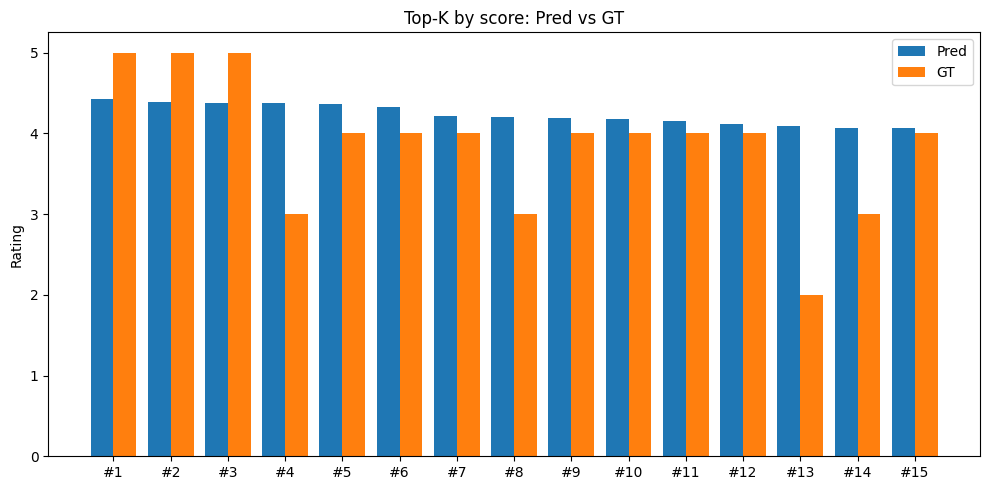

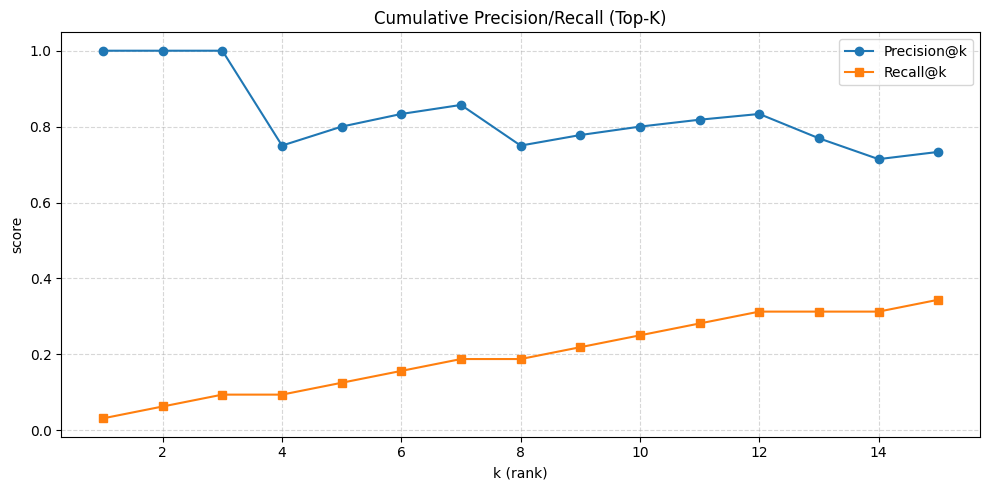

In [80]:
uid, g_sorted = user_report(uid=None, K=15, pos_threshold=4)
plot_user_ranking(g_sorted, K=15, pos_threshold=4)